# This is a Machine Hack Competition
## House Pricing Prediction Challenge
* Now this competion is closed but you can still make submissions if you wish.
* Link to Competition-https://www.machinehack.com/hackathons/house_price_prediction_beat_the_benchmark/overview
* Dataset for kaggle notebook- https://www.kaggle.com/jassican/house-price-prediction-challenge-machine-hack

### Things That Work
1. Features (First extracted city and locality features from address column)
    1. SQUARE_FT variable mean,max, min, variance encoded with locality
    1. SQUARE_FT variable mean,max, min, variance encoded with City
    1. count of unique locality in each city
1. K-fold, I have used K as 10 here
1. Ensembeling of 3, 10 fold models- Light Gradient Bossting, Extreme Gradient Boosting, Catboost (with large no. of n_estimators(iterations in catboost) and early_stopping_rounds )
1. Remove dublicate rows from train data while training and used mean of log target variable in test data which are exactly dublicate from train set.
1. Fitting Log of target variable in training and then taking its inverse while submitting. because by default models minimize RMSE and by doing so it will minimize RMSLE, which is exact evaluation metric for this competition.

### Just by using above 5 steps you can achieve Rank 7, I myself has achieved rank 9 in this competition.

### Things which may work
1. You can observe that city and locality turned out to very important variable in this competition, but there are few problem with these variables, same address are given in 2 or 3 different form multiple times, like 'Rajiv Gandhi Nagar,Maharashtra' and 'Rajiv Gandhi Nagar,Mumbai', 'Anand Nagar,Maharashtra'and 'Anand Nagar,Pune'. Correcting them can boost your score (prefer to always have city name instead of state. Maharashtra only come around 5% times in data)
1. locality and City variables encoded with square_ft work very well, you can also try group of other variables like locality and POSTED_BY with SQUARE_FT or even grouped of other variable with locality and city variable. 
1. There is problem also with some variables like SQUARE_FT, it is less than 90 (even less tha 10 for few), you can improve that values(by replacig them to missing or by multipling by a factor of 10 or 100), You may also bin values of BHK_no. as with even higher BHK_NO. values mean price is decreasing. Same way  Longitude and latitude data is not in range of Indian latitude and longitude for some observation, whereas data is only of india. (Indian latitude range 8°4' north to 37°6' north and longitude range 68°7' east to 97°25'). But be careful there may be pattern in data like whenever latitude and longitude are out of range price are less compare to other. Additing to this here Latitudes as given as longitude and vice-versa.
1. I have removed only those dublicate columns from train data which are having same output, but there are also few columns( around 100) which have same input but different output(you can find dublicacy by ignoring adress columns also). Additinally I have remove Dublicates just before training. Use them while genrating new features, you can try by removing before genrating new features.
1. Genrating few more fetures, and better tuning of all parameters and even some better way of ensembeling or stacking can also help.

### Things which not work
* After Tuning model parameters oof (out of fold) score improves but but score on leaderboard is decreasing, because tuning is resulting in making all different fold models similar and the benifit which we are getting through ensembeling of multiple fold, we are losing that. ( may be tring with lesser fold while tuning can help)
* Added SQUARE_FT variable median encoded with City and locality

### INDEX
* [Basic Visulization](#1)
* [Feature Engineering](#2)
* [Model Fitting](#3)

In [1]:
# import Libraries
import pandas as pd
import numpy as np
import matplotlib as pyplot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# to see all the comands result in a single kernal 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# to increase no. of rows and column visibility in outputs
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)
pd.set_option('display.width', 2000)

#To ignore warnings
import warnings
warnings.simplefilter('ignore')

In [2]:
#Import data
train = pd.read_csv(r'../input/house-price-prediction-challenge-machine-hack/Train.csv')
test = pd.read_csv(r'../input/house-price-prediction-challenge-machine-hack/Test.csv')
sample = pd.read_csv(r'../input/house-price-prediction-challenge-machine-hack/sample_submission.csv')

 **Basic Visulization**

In [3]:
# Having a look at data and its shape 
train.head()
test.head()
train.shape ,test.shape ,sample.shape

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE
0,Owner,0,0,1,BHK,545.171340,1,1,"Kamrej,Surat",21.262000,73.047700
1,Dealer,1,1,2,BHK,800.000000,0,0,"Panvel,Lalitpur",18.966114,73.148278
2,Dealer,0,0,2,BHK,1257.096513,1,1,"New Town,Kolkata",22.592200,88.484911
3,Dealer,0,0,3,BHK,1400.329489,1,1,"Kalwar Road,Jaipur",26.988300,75.584600
4,Owner,0,0,1,BHK,430.477830,1,1,"Mai Mandir,Nadiad",22.700000,72.870000


((29451, 12), (68720, 11), (68720, 1))

In [4]:
# Dublicacy Analyses
duplicate_input_train = train[train.duplicated(subset=['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'BHK_OR_RK', 'SQUARE_FT', 'READY_TO_MOVE', 'RESALE', 'ADDRESS', 'LONGITUDE', 'LATITUDE'])]
duplicate_Rows_train = train[train.duplicated()]
duplicate_Rows_test = test[test.duplicated()]
df=pd.concat([train,test],ignore_index=True )
duplicate_input_DF = df[df.duplicated(subset=['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'BHK_OR_RK', 'SQUARE_FT', 'READY_TO_MOVE', 'RESALE', 'ADDRESS', 'LONGITUDE', 'LATITUDE'])]
duplicate_input_train.shape ,duplicate_Rows_train.shape ,duplicate_Rows_test.shape ,duplicate_input_DF.shape 

((537, 12), (401, 12), (2470, 11), (4672, 12))

In [5]:
# to check type of columns and identify whether missing values exist or not
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29451 entries, 0 to 29450
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   POSTED_BY              29451 non-null  object 
 1   UNDER_CONSTRUCTION     29451 non-null  int64  
 2   RERA                   29451 non-null  int64  
 3   BHK_NO.                29451 non-null  int64  
 4   BHK_OR_RK              29451 non-null  object 
 5   SQUARE_FT              29451 non-null  float64
 6   READY_TO_MOVE          29451 non-null  int64  
 7   RESALE                 29451 non-null  int64  
 8   ADDRESS                29451 non-null  object 
 9   LONGITUDE              29451 non-null  float64
 10  LATITUDE               29451 non-null  float64
 11  TARGET(PRICE_IN_LACS)  29451 non-null  float64
dtypes: float64(4), int64(5), object(3)
memory usage: 2.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68720 entries, 0 to 68719
Data columns (total 11 co

In [6]:
# Genrate a new column substitude it with mean of log of target column, we will use this before submission
train['is_train']=1
test['is_train']=0
train['TARGET_log']=np.log1p(train['TARGET(PRICE_IN_LACS)'])
df=pd.concat([train,test],ignore_index=True)
df['T1_log_dub']=df.groupby(['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA','BHK_NO.', 'BHK_OR_RK', 'SQUARE_FT', 'READY_TO_MOVE', 'RESALE', 'ADDRESS', 'LONGITUDE', 'LATITUDE'])['TARGET_log'].transform('mean')
df['t1_dub']=np.exp(df['T1_log_dub'])-1
train=df[df['is_train']==1]
test=df[df['is_train']==0]
test.shape
test.t1_dub.isna().sum()

(68720, 16)

66434

2286 test data values are filled

In [7]:
t2=test[test['t1_dub'].isna() == True]
t2[t2.duplicated()].shape

(1849, 16)

But still test data has lot of missing values

In [8]:
#Conerting categorical variable to numeric
train['BHK_OR_RK']=train['BHK_OR_RK'].replace({'BHK':0,'RK':1})
train['POSTED_BY']=train['POSTED_BY'].replace({'Owner':0,'Dealer':1,'Builder':2})
test['BHK_OR_RK']=test['BHK_OR_RK'].replace({'BHK':0,'RK':1})
test['POSTED_BY']=test['POSTED_BY'].replace({'Owner':0,'Dealer':1,'Builder':2})

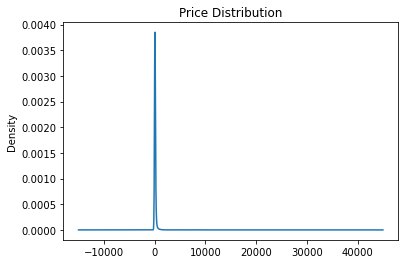

In [9]:
# found out that there is no. missing value and only one address as object type variable
# Target varibale distribution 
train['TARGET(PRICE_IN_LACS)'].plot(kind = 'density', title = 'Price Distribution')

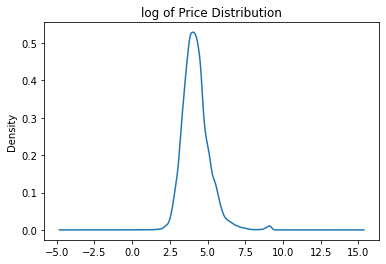

In [10]:
# Transforming target varible(log transformation), because target is to optimize Root mean square log error
# and checking log transformed varibale distribution
#train['TARGET_log']=np.log1p(train['TARGET(PRICE_IN_LACS)'])
train['TARGET_log'].plot(kind = 'density', title = 'log of Price Distribution')

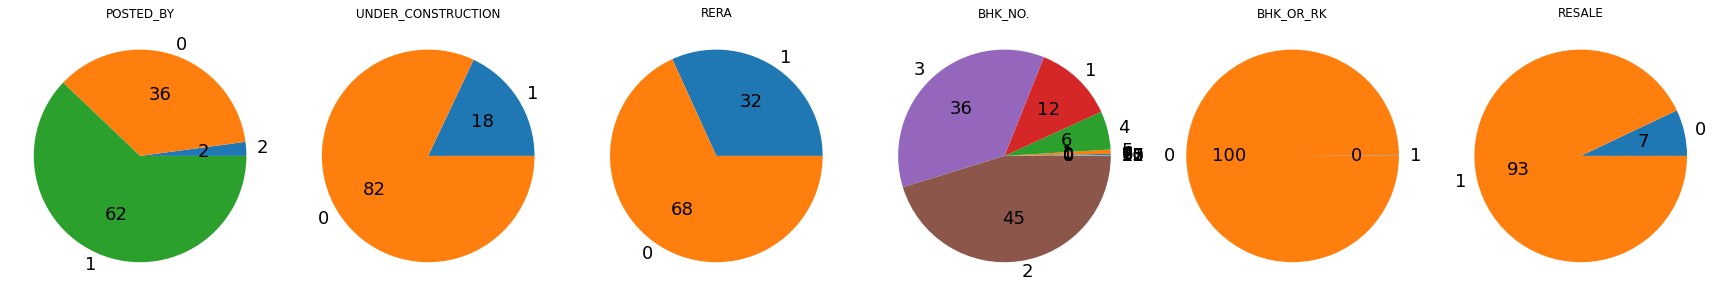

In [11]:
# Analysing distribution in Categorical varibales 
cat_cols = ['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'BHK_OR_RK', 'RESALE']
fig, axes = plt.subplots(1,6, figsize=(24, 10))

for i, c in enumerate(['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'BHK_OR_RK', 'RESALE']):
    _ = train[c].value_counts()[::-1].plot(kind = 'pie', ax=axes[i], title=c, autopct='%.0f', fontsize=18)
    _ = axes[i].set_ylabel('')
    
_ = plt.tight_layout()

* we found out that 99% of houses are either 1,2,3,or 4 BHK 
* almost all the houses are BHK 

In [12]:

# to get exact values of distribution 
# cat_col=['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'BHK_OR_RK', 'RESALE']
# for col in cat_col:
#  train[col].value_counts()/len(train)

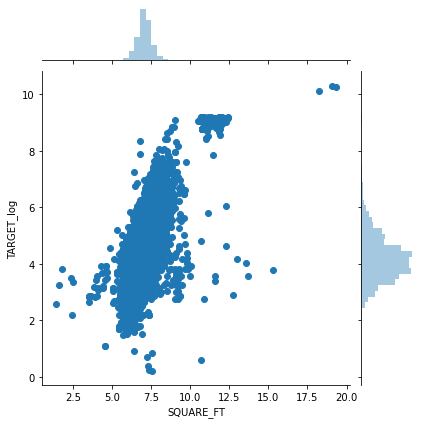

In [13]:
sns.jointplot(x=np.log1p(train['SQUARE_FT']), y=train['TARGET_log'])

find out that there are few houses with very less value of SQUARE_FT(which are ven not possible)

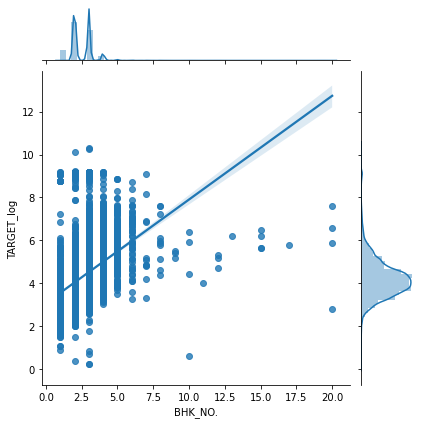

In [14]:
sns.jointplot(x=(train['BHK_NO.']), y=train['TARGET_log'],kind='reg')

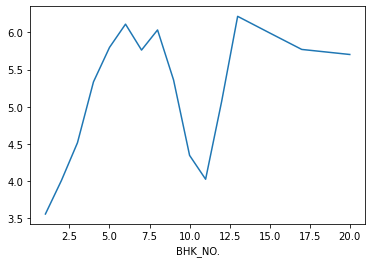

In [15]:
 train.groupby('BHK_NO.')['TARGET_log'].mean().plot()

We found that as we expect TARGET_log should increase with increasing BHK_NO. values, it is not following with that. One reason for that can also be there are very few houses(~1%) with BHK_NO. greater than 4. so we can also bin BHK_no. column here

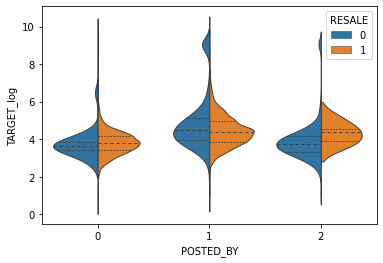

In [16]:
sns.violinplot(data=train, x="POSTED_BY", y="TARGET_log", hue="RESALE",split=True, inner="quart", linewidth=1)

Most of very High price houses are which are not for RESALE.

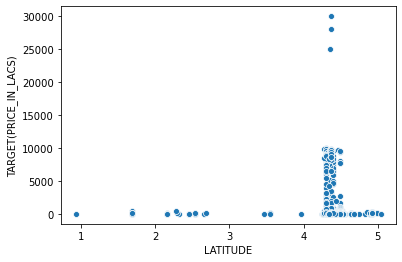

In [17]:
sns.scatterplot(x=np.log1p(train['LATITUDE']), y=train['TARGET(PRICE_IN_LACS)'])

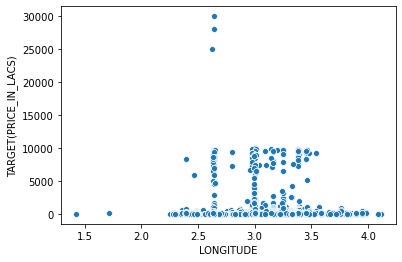

In [18]:
sns.scatterplot(x=np.log1p(train['LONGITUDE']), y=train['TARGET(PRICE_IN_LACS)'])

Longitude and latitude values which are out of indian range are giving less values, that why i not try to thing of any method to improve these values, but still can and save our outcomes in a different column, that is the longitude latitude are corrct or not

<Figure size 1080x576 with 0 Axes>

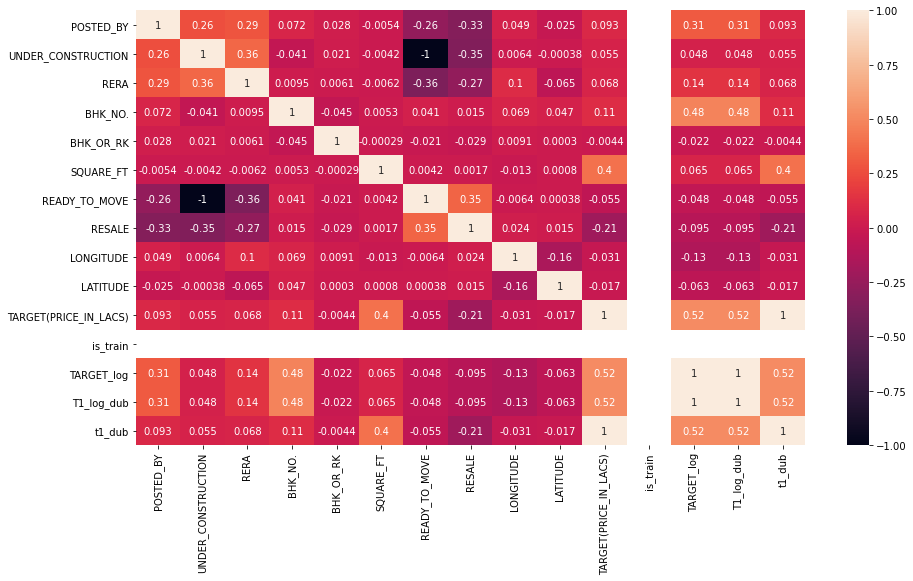

In [19]:
# Checking correlation
plt.figure(figsize=(15, 8))
sns.heatmap(train.corr(),annot=True)

READY_TO_MOVE and UNDER_CONSTRUCTION have correlation -1 so both giving same information, we can remove one of variable 

# Feature Engineering

In [20]:
train['sq_per_room']=train['SQUARE_FT']/train['BHK_NO.']
test['sq_per_room']=test['SQUARE_FT']/test['BHK_NO.']

In [21]:
# Extracting name of city and locality of house
train['City']=train['ADDRESS'].str.split(',').str.get(-1)
train['locality']=train['ADDRESS'].str.split(',').str.get(-2)
test['City']=test['ADDRESS'].str.split(',').str.get(-1)
test['locality']=test['ADDRESS'].str.split(',').str.get(-2)

In [22]:
# train['City'].value_counts()/len(train)
# Maharashtra is not a city but coming 5% times, we can replace that for furthur improvement, can use above command to see

In [23]:
train['is_train']=1
test['is_train']=0
df=pd.concat([train,test])
df['SQUARE_FT']=np.log1p(df['SQUARE_FT'])
df['loc_'+'SQUARE_FT'+'mean'] = df.groupby(['locality'])['SQUARE_FT'].transform('mean')
df['loc_'+'SQUARE_FT'+'median'] = df.groupby(['locality'])['SQUARE_FT'].transform('median')
df['loc_'+'SQUARE_FT'+'_max'] = df.groupby(['locality'])['SQUARE_FT'].transform('max')
df['loc_'+'SQUARE_FT'+'_min'] = df.groupby(['locality'])['SQUARE_FT'].transform('min')
df['loc_'+'SQUARE_FT'+'_var'] = df.groupby(['locality'])['SQUARE_FT'].transform('std')
df['city_'+'SQUARE_FT'+'_mean'] = df.groupby(['City'])['SQUARE_FT'].transform('mean')
df['city_'+'SQUARE_FT'+'_median'] = df.groupby(['City'])['SQUARE_FT'].transform('median')
df['city_'+'SQUARE_FT'+'_max'] = df.groupby(['City'])['SQUARE_FT'].transform('max')
df['city_'+'SQUARE_FT'+'_min'] = df.groupby(['City'])['SQUARE_FT'].transform('min')
df['city_'+'SQUARE_FT'+'_var'] = df.groupby(['City'])['SQUARE_FT'].transform('std')
df['loc_'+'city_'+'SQUARE_FT'+'mean'] = df.groupby(['locality','City'])['SQUARE_FT'].transform('mean')
df['loc_'+'count'] = df.groupby(['locality'])['locality'].transform('count')
df['City_'+'count'] = df.groupby(['City'])['City'].transform('count')
df['city'+'loc_count'] = df.groupby(['City'])['locality'].transform('count')
df['city'+'loc_unique'] = df.groupby(['City'])['locality'].transform('nunique')
df['PB_UC']=train['POSTED_BY']*3+train['UNDER_CONSTRUCTION']
#df['loc_'+'BHK_NO'+'_mean'] = df.groupby(['loc'])['SQUARE_FT'].transform('mean')
train=df[df['is_train']==1]
test=df[df['is_train']==0]

In [24]:
# to see same address with different city name can use below command
encode=df.groupby(['locality'])['City'].unique()
df['unique']=df['locality'].map(encode)
df['count_city']=df.groupby(['locality'])['City'].transform('nunique')
df.sort_values(by='count_city',ascending=False).head(3)

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),is_train,TARGET_log,T1_log_dub,t1_dub,sq_per_room,City,locality,loc_SQUARE_FTmean,loc_SQUARE_FTmedian,loc_SQUARE_FT_max,loc_SQUARE_FT_min,loc_SQUARE_FT_var,city_SQUARE_FT_mean,city_SQUARE_FT_median,city_SQUARE_FT_max,city_SQUARE_FT_min,city_SQUARE_FT_var,loc_city_SQUARE_FTmean,loc_count,City_count,cityloc_count,cityloc_unique,PB_UC,unique,count_city
62101,0,0,0,2,0,6.606678,1,1,"Behind Deshmukh Lawns,,Amravati",20.933330,77.750000,NaN,0,NaN,NaN,NaN,369.510135,Amravati,,7.020613,6.908755,8.597199,6.074184,0.539595,6.719703,6.803623,8.294300,2.090115,0.630396,6.673257,40,75,75,46,NaN,"[Karjat, Kolkata, Surat, Pune, Lalitpur, Banga...",27
96179,0,0,0,2,0,6.621506,1,1,"Saru Section Road, Nr Jamnagar Dairy,,Jamnagar",22.470000,70.070000,NaN,0,NaN,NaN,NaN,375.037504,Jamnagar,,7.020613,6.908755,8.597199,6.074184,0.539595,6.857525,6.921893,8.969306,5.635502,0.416373,6.621506,40,206,206,105,NaN,"[Karjat, Kolkata, Surat, Pune, Lalitpur, Banga...",27
13623,0,0,0,2,0,6.746569,1,1,"Shivneri Colony,,Pune",20.934264,77.783878,35.0,1,3.583519,3.583519,35.0,425.066796,Pune,,7.020613,6.908755,8.597199,6.074184,0.539595,6.998174,6.957527,11.575619,1.870264,0.575077,6.681870,40,6591,6591,508,0.0,"[Karjat, Kolkata, Surat, Pune, Lalitpur, Banga...",27


You can increase the value under head to 100 or 1000 to see more locality values with distinct city values, but remember that, few of them are genuine, there is possiblity that in two different city same name of locality can exist, but sometimes some arbitary name is given or state name is given instead of City you can correct that. 

In [25]:
train.shape
train.drop_duplicates(subset=['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'BHK_OR_RK', 'SQUARE_FT', 'READY_TO_MOVE', 'RESALE', 'ADDRESS', 'LONGITUDE', 'LATITUDE','TARGET_log'],keep ='last', inplace = True,ignore_index=True)
train.shape

(29451, 35)

(29050, 35)

Remove approax 1% dublicate data 

# Model Fitting

In [26]:
#Importing Packages
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV,KFold
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [27]:
test.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),is_train,TARGET_log,T1_log_dub,t1_dub,sq_per_room,City,locality,loc_SQUARE_FTmean,loc_SQUARE_FTmedian,loc_SQUARE_FT_max,loc_SQUARE_FT_min,loc_SQUARE_FT_var,city_SQUARE_FT_mean,city_SQUARE_FT_median,city_SQUARE_FT_max,city_SQUARE_FT_min,city_SQUARE_FT_var,loc_city_SQUARE_FTmean,loc_count,City_count,cityloc_count,cityloc_unique,PB_UC
29451,0,0,0,1,0,6.302933,1,1,"Kamrej,Surat",21.262000,73.047700,NaN,0,NaN,NaN,NaN,545.171340,Surat,Kamrej,6.796696,6.884629,7.346365,6.302933,0.311907,7.184105,7.148406,9.297443,2.397895,0.553433,6.796696,13,1449,1449,174,NaN
29452,1,1,1,2,0,6.685861,0,0,"Panvel,Lalitpur",18.966114,73.148278,NaN,0,NaN,NaN,NaN,400.000000,Lalitpur,Panvel,6.669816,6.663616,7.898644,4.933293,0.503415,6.927322,6.908755,12.756906,4.158884,0.634453,6.612911,170,10063,10063,1016,NaN
29453,1,0,0,2,0,7.137355,1,1,"New Town,Kolkata",22.592200,88.484911,NaN,0,NaN,NaN,NaN,628.548257,Kolkata,New Town,7.294144,7.297143,12.119422,5.993961,0.547390,7.047386,7.004161,12.119422,4.700489,0.472686,7.294144,464,5850,5850,588,NaN
29454,1,0,0,3,0,7.245177,1,1,"Kalwar Road,Jaipur",26.988300,75.584600,NaN,0,NaN,NaN,NaN,466.776496,Jaipur,Kalwar Road,6.960707,7.003929,8.998815,6.552804,0.306906,7.145348,7.151485,10.159710,3.258097,0.440459,6.960707,85,3229,3229,319,NaN
29455,0,0,0,1,0,6.067216,1,1,"Mai Mandir,Nadiad",22.700000,72.870000,NaN,0,NaN,NaN,NaN,430.477830,Nadiad,Mai Mandir,6.579249,6.579249,7.091282,6.067216,0.724124,6.968689,6.908755,15.176487,4.276690,1.581456,6.579249,2,41,41,33,NaN


In [28]:
def run_gradient_boosting(clf,k, fit_params, train, test, features):
  N_SPLITS = k
  oofs = np.zeros(len(train))
  preds = np.zeros((len(test)))

  folds = KFold(n_splits = N_SPLITS,random_state=2021)

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train[TARGET_COL])):
    print(f'\n------------- Fold {fold_ + 1} -------------')
    target=train[TARGET_COL]
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    X_test = test[features]

    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)
    preds_val = clf.predict(X_val)
    preds_test = clf.predict(X_test)
    preds_test1=(np.exp(preds_test)-1)
    fold_score =  np.sqrt(mean_squared_error(y_val,preds_val)) 
    print(f'\n RMLSE score for validation set is {fold_score}')

    oofs[val_idx] = (np.exp(preds_val)-1)
    preds += preds_test1 / N_SPLITS


  oofs_score = np.sqrt(mean_squared_error(target, np.log1p(oofs)))
  print(f'\n\n rmlse score for oofs is {oofs_score}')

  return oofs, preds

In [29]:
train.columns

Index(['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'BHK_OR_RK', 'SQUARE_FT', 'READY_TO_MOVE', 'RESALE', 'ADDRESS', 'LONGITUDE', 'LATITUDE', 'TARGET(PRICE_IN_LACS)', 'is_train', 'TARGET_log', 'T1_log_dub', 't1_dub', 'sq_per_room', 'City', 'locality', 'loc_SQUARE_FTmean', 'loc_SQUARE_FTmedian', 'loc_SQUARE_FT_max', 'loc_SQUARE_FT_min', 'loc_SQUARE_FT_var', 'city_SQUARE_FT_mean', 'city_SQUARE_FT_median', 'city_SQUARE_FT_max', 'city_SQUARE_FT_min', 'city_SQUARE_FT_var', 'loc_city_SQUARE_FTmean', 'loc_count', 'City_count', 'cityloc_count', 'cityloc_unique', 'PB_UC'], dtype='object')

In [30]:
# Selecting Columns to take in the model
model_col=['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA','BHK_NO.', 'SQUARE_FT', 'RESALE','LONGITUDE', 'LATITUDE', 'BHK_OR_RK', 'loc_SQUARE_FTmean', 'loc_SQUARE_FT_max', 'loc_SQUARE_FT_min', 'loc_SQUARE_FT_var', 'city_SQUARE_FT_mean', 'city_SQUARE_FT_max', 'city_SQUARE_FT_min', 'city_SQUARE_FT_var','cityloc_count']
cat_col=['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'BHK_OR_RK', 'RESALE']
tar_col=['TARGET(PRICE_IN_LACS)']

In [31]:
from sklearn.model_selection import GridSearchCV,StratifiedKFold,KFold

xgb = XGBRegressor(n_estimators = 8000,
#                        learning_rate = 0.05,
#                       colsample_bytree = 0.76,
                        )
fit_params = {'verbose': False, 'early_stopping_rounds': 100}
TARGET_COL= 'TARGET_log'
features =model_col
xgb_oofs, xgb_preds = run_gradient_boosting(xgb,10, fit_params, train, test, features)


------------- Fold 1 -------------

 RMLSE score for validation set is 0.24957457008701076

------------- Fold 2 -------------

 RMLSE score for validation set is 0.28191394016229776

------------- Fold 3 -------------

 RMLSE score for validation set is 0.2922029104338697

------------- Fold 4 -------------

 RMLSE score for validation set is 0.282851745099516

------------- Fold 5 -------------

 RMLSE score for validation set is 0.2808508150410477

------------- Fold 6 -------------

 RMLSE score for validation set is 0.2829377851542719

------------- Fold 7 -------------

 RMLSE score for validation set is 0.2646145119369259

------------- Fold 8 -------------

 RMLSE score for validation set is 0.28873490445191885

------------- Fold 9 -------------

 RMLSE score for validation set is 0.2934613898266544

------------- Fold 10 -------------

 RMLSE score for validation set is 0.30136909459682815


 rmlse score for oofs is 0.28220793068630434


0.2821 on oof, 0.2632 on public, 0.2657 on private can get rank 11 with this

### This  is to get Rough idea of how much each step matters, 
* I have not fixed random seed in kfold that time, so score may vary a bit for you

* 0.2917 ,5 fold only 2 genrated features city and loc sqrt_mean
* 0.2911     , 5 fold only 2 genrated features city and loc log_sqrt_mean
* 0.2892     , 5 fold with 8 genrated fetures mean , max , min, var, of city and loc with log_sqrt 
* Not used ,0.2879   , 5 fold with 9 variables new variable city mean if count>2
* Not used ,0.2891   , 5 fold with 9 variables new variable city mean if count>1
* Not used ,0.2912  , added variable Loc count 
* Not used ,0.2892  , added city loc count 
* 0.2872  , added cityloc unique values 
* Not used  ,0.2923, added median of sqrt grouped with city and loc 
----------------------------------------------------
### 0.2632 on public leader board # 0.2823 on validation set # Kfold =10 
----------------------------------------------------

In [32]:
# Here You can even extract your training data and analyse on which outcomes you are getting most error
# and take further step accordingly
train['pred']=xgb_oofs
train['error']=(train['TARGET_log']-np.log1p(train['pred']))**2
vis=train[model_col]
vis.to_csv('train_out.csv',index=False)

In [33]:

lgb = LGBMRegressor(n_estimators=5000, importance_type='gain',
#                          learning_rate = 0.05,
#                          colsample_bytree = 0.76,
                        )
fit_params = {'verbose': False, 'early_stopping_rounds': 100}
TARGET_COL= 'TARGET_log'
features =model_col
lgb_oofs, lgb_preds = run_gradient_boosting(lgb,10, fit_params, train, test, features)


------------- Fold 1 -------------

 RMLSE score for validation set is 0.25951807658172327

------------- Fold 2 -------------

 RMLSE score for validation set is 0.27998571187154164

------------- Fold 3 -------------

 RMLSE score for validation set is 0.288707108172276

------------- Fold 4 -------------

 RMLSE score for validation set is 0.27737700864911125

------------- Fold 5 -------------

 RMLSE score for validation set is 0.27452072220918466

------------- Fold 6 -------------

 RMLSE score for validation set is 0.2880565660749574

------------- Fold 7 -------------

 RMLSE score for validation set is 0.2647736364814016

------------- Fold 8 -------------

 RMLSE score for validation set is 0.26284024812598916

------------- Fold 9 -------------

 RMLSE score for validation set is 0.2908131539125802

------------- Fold 10 -------------

 RMLSE score for validation set is 0.30361737790649473


 rmlse score for oofs is 0.27934128223524024


0.2785 oof, 0.2660 public leaderboard, 0.2672 private leaderboard,
* you can give categorical_column also as categorical_column in lgb it can improve your score

In [34]:
# You can even see Plot of your error with iteration in catboost, by adding plot=True in fit_parametrs
from catboost import CatBoostRegressor
cb = CatBoostRegressor(iterations=10000,
                       learning_rate = 0.1,
#                         colsample_bytree = 0.76,
                        )
fit_params = {'verbose': False , 'early_stopping_rounds': 100}
TARGET_COL= 'TARGET_log'
features =model_col
cb_oofs, cb_preds = run_gradient_boosting(cb,10, fit_params, train, test, features)


------------- Fold 1 -------------

 RMLSE score for validation set is 0.24850886224366708

------------- Fold 2 -------------

 RMLSE score for validation set is 0.28344086084750725

------------- Fold 3 -------------

 RMLSE score for validation set is 0.2854417375733881

------------- Fold 4 -------------

 RMLSE score for validation set is 0.2759740575700078

------------- Fold 5 -------------

 RMLSE score for validation set is 0.2746575784286145

------------- Fold 6 -------------

 RMLSE score for validation set is 0.2859553543882909

------------- Fold 7 -------------

 RMLSE score for validation set is 0.25924761428676163

------------- Fold 8 -------------

 RMLSE score for validation set is 0.26365375869401797

------------- Fold 9 -------------

 RMLSE score for validation set is 0.28893191836686816

------------- Fold 10 -------------

 RMLSE score for validation set is 0.30250073181026543


 rmlse score for oofs is 0.27724578779262926


* In catboost learning rate decreases as iterations increase, but i have kep it constant for faster result
* can also added categorical feature in fit_params to improve your model
* 0.2757 on out of fold, 0.2644 on public leaderboard, 0.2673 on private leaderboard

In [35]:
# you can change predictions to xgb_pred and lgb_pred to extract their outputs
test['t2']=cb_preds
sample['TARGET(PRICE_IN_LACS)']=np.where(test['t1_dub'].isna()==True,test['t2'],test['t1_dub'])
sample.to_csv('10fold_ccccb_2mod_final.csv',index=False)

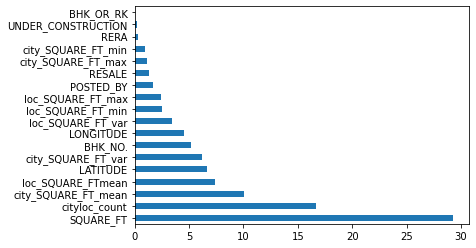

In [36]:
# Checking Feature Importance
# you can also change cb to xgb or lgb to see their imporatance of variable
feat_importances = pd.Series(cb.feature_importances_, index=model_col)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

# Averaging of 3  models to get best score 

To decide weights by this way averaging oof is not totally correct, because on each test set point outcome is average of each fold model, but here we are using differnt fold outputs for different outcomes in oof set. 

In [37]:
avg= 0.4*xgb_oofs +0.2* lgb_oofs + 0.4*cb_oofs
np.sqrt(mean_squared_error(train[TARGET_COL], np.log1p(avg)))

0.2721597247520549

In [38]:
#avg_test= 0.34*xgb_preds+ 0.33*lgb_preds+0.33*cb_preds
avg_test= 0.4*xgb_preds+ 0.2*lgb_preds+0.4*cb_preds
test['t2']=avg_test
sample['TARGET(PRICE_IN_LACS)']=np.where(test['t1_dub'].isna()==True,test['t2'],test['t1_dub'])
sample.to_csv('10_fold_3_424_equal_model_ensembeling.csv',index=False)

-------------------------------------------------
### 0.2724 on oof , 0.2610 on public leaderboard, 0.26311 on private leaderboard
### You can Secured Rank 7 in this competiotion by this solution 
-------------------------------------------------
* may be using stacking will boost score bit more.

* If you reach till here Hopefully you have learned or atleast reviced few concept, which may help you in your next upcoming competition
### Don't forget to Upvote this Notebook and share your feedback in comment section
* if i get positive responce, soon i will come up with few more notebooks and upgrade this one also with methods i mention in "Things which may work" section

## Special Thanks to few people for clearning my doubts and sharing insightful Notebooks
### @NikhilMishra @gcspkmdr @Vetrivel-PS @Anil Betta @Piyush Raj Gupta